# Temperature Sensor to SQL Database Script

In [1]:
# Python libraries for working with files
import os, csv, sys, datetime, glob, itertools

# Python library for timeseries
from pandas.tseries.offsets import *

# Python libraries for data
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# Python libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Python libraries for working with SQL
import sqlite3

# My functions
import sensor_functions as sf

## Autoreload all external modules

In [2]:
%load_ext autoreload
%autoreload 2

## Connect with SQL DB to pull site data

In [11]:
# Create engine
from sqlalchemy import MetaData, Table, Column, Integer, String, create_engine, update, insert
import pymysql

# Amazon RDS login credentials
driver = 'mysql+pymysql'
uname = 'om_rw'
pword = 'wwTLeJZRwdXGGkL5BcYdy9ddSsuvayY'
# host = 'oandmdb1.cbvjxoyvmycf.eu-central-1.rds.amazonaws.com' # From the office
host = 'localhost' # From home
port = '3306'
dbase= 'IAC_MASTER'
ssl_cert = r'C:\\etc\\default\\rds-combined-ca-bundle.pem'

# The database login for connection to Amazon RDS
URI = str(driver+'://'+uname+':'+pword+'@'+host+':'+port+'/'+dbase)

# SSL Arguments for connection into 
ssl_args ={'ssl': {'ca': 'C:\\etc\\default\\rds-combined-ca-bundle.pem'}}

engine = create_engine(URI, connect_args=ssl_args, echo=False)

# Using SQLALchemy - create engine and connect into database
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
metadata = MetaData()

from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session= Session()

# Using SQLAlchemy load the schema from the tickets table
Temperature = Table('performance_data_temperature', metadata, autoload=True, autoload_with=engine)


# Connect to the engine
connection = engine.connect()
with engine.begin() as connection:
    report_param_df = pd.read_sql_table('parameters_reporting', connection)
    contract_param_df = pd.read_sql_table('parameters_contract', connection)
connection.close()


# Set the site_id as the index so it is accessible by site name
report_param_df = report_param_df.set_index('site_id')
contract_param_df = contract_param_df.set_index('site_id')

## Outlier removal 

In [12]:
def remove_outliers(df, std_dev, remove=False):
    
    site_sensor_df = pd.DataFrame(df.iloc[:,0])
    df= pd.DataFrame(df.iloc[:,1])
    site_name_for_cols = df.columns.values
    df.columns = ['sensor_temp']
    
    # Calculate the daily Mean
    df_mean = df.groupby(df.index.day).mean()
    df_mean.columns = ['day_mean']
    
    # Calculate the daily Median
    df_median = df.groupby(df.index.day).median()
    df_median.columns = ['day_median']

    # Calculate the daily Min
    df_min = df.groupby(df.index.day).min()
    df_min.columns = ['day_min']

    # Calculate the daily Max
    df_max = df.groupby(df.index.day).max()
    df_max.columns = ['day_max']

    # Calculate the daily Standard deviation
    df_std = df.groupby(df.index.day).std()
    df_std.columns = ['day_std_dev']

    # Combine dataframe of these daily calculated values
    df_agg = pd.concat([df_median, df_mean, df_std, df_min, df_max], axis=1)
    
    
    # Reindex aggregate dataframe - so that the index is the date of the month
    df_agg['day_of_month'] = (df_agg.index)
    df_agg['day_of_month'] = df_agg['day_of_month'].astype(int)
    df_agg['day_of_month'] = pd.to_datetime(df_agg['day_of_month'].astype(str)+'-'+yyyymm[4:]+'-'+yyyymm[:4], format = '%d-%m-%Y')
    df_agg = df_agg.set_index('day_of_month')
        
    # Join the aggregate dataframe to original data
    df_agg = df_agg.reindex(quarter_mins).fillna(method='ffill')
    df_calc =pd.concat([df,df_agg], axis=1)
    
    # A new column to evaluate how many standard deviations from the mean each value is
    df_calc['day_outlier'] = np.abs((df_calc.sensor_temp - df_calc.day_mean)/df_calc.day_std_dev)
    df_calc.index.name = site
    df_calc = df_calc.dropna(how='any')
    # sf.print_full(df_calc['2016-08-24']) # To print out specific days - debugging

    print('--POSSIBLE OUTLIERS--')
    
    outlier_bool = ((df_calc['day_outlier']>std_dev) & (df_calc['sensor_temp']>34)) | ((df_calc['day_outlier']>std_dev) & (df_calc['sensor_temp']<0))
    print(df_calc[outlier_bool])
    
    # Set the outliers as null
    if remove==True:
        df_calc['sensor_temp'][outlier_bool] = np.nan
        
        # print('--OUTLIERS THAT HAVE BEEN MADE NULL--')
        # print(df_calc[(df_calc['day_outlier']>std_dev) & (df_calc['sensor_temp']>20)])

    print('--NULL ROWS AND VALUES--')
    # print(df_calc[df_calc['sensor_temp'].isnull()])
    print(df_calc['sensor_temp'].isnull().sum())
    
    # Drop all temporary calculation columns
    df_result = df_calc.drop(['day_median', 'day_mean', 'day_std_dev', 'day_min', 'day_max', 'day_outlier'], axis=1)
    df_result.columns = site_name_for_cols
    df_result = pd.concat([site_sensor_df, df_result], axis=1)
    
    return df_result

## Plotting functions

In [13]:
# Plots the min, max and mean over the month - aggregate data
def month_plot(frame):
    plt_frame = frame
    # plt_frame.drop('calculation_completeness_factor', axis=1, inplace=True)

    col_name = plt_frame.columns[3]
    site_name = plt_frame[plt_frame.columns[0]].unique()[0].upper()+ ' ' + yyyymm + ' '

    sensor_type_1 = plt_frame[plt_frame.columns[3]].unique()[0]
    sensor_type_2 = plt_frame[plt_frame.columns[3]].unique()[1]

    daylight1 = plt_frame[plt_frame[col_name]== sensor_type_1].drop('calculation_completeness_factor', axis=1)
    daylight2 = plt_frame[plt_frame[col_name]== sensor_type_2].drop('calculation_completeness_factor', axis=1)
    return daylight1.plot(figsize=(15,10), title=site_name + sensor_type_1 ), daylight2.plot(figsize=(15,10), title=site_name + sensor_type_2)

In [14]:
# Plot two series or dataframe against each other

def comp_plot(frame1, frame2, site_name):
    frame1 = frame1.resample('H').mean()
    frame2 = frame2.resample('H').mean()
    ax = frame2.plot(figsize=(15,10), title=site_name.upper()+' '+yyyymm)
    line_title = frame2.columns.values.tolist() + frame1.columns.values.tolist()
    ax.legend(labels=line_title)
    return ax, frame1.plot(ax=ax)

## Month and Year for Analysis


In [15]:
yyyymm = sf.year_month(2017, 1)
yyyymm

'201701'

## Set up the time period for the calculation - per month


In [16]:
start_hour, end_hour = sf.month_duration(yyyymm)
start_hour, end_hour

(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-01-31 23:59:00'))

In [17]:
original_dir = r'C:\Users\eric\Google Drive\SolarCentury Data\07_Dev\01_Temperature'
original_dir

'C:\\Users\\eric\\Google Drive\\SolarCentury Data\\07_Dev\\01_Temperature'

## Concatenate full path given site name and site

In [18]:
def site_path(site, month):    
    
    # Access the Dropbox folder for each site
    db_path = 'C:\\Users\\eric\\Dropbox (Solarcentury PM Team)\\PV Monitoring Support\\00 - Projects'
    proj_path = 'analysis\\PAC-PR data\\00 - Full months'
    proj_code = contract_param_df.ix[site]['job_number']+ ' ' + contract_param_df.ix[site]['project_name']
    additional_path = report_param_df.ix[site]['input_additional_folder']
    if additional_path is None:
        full_path = os.path.join(db_path,proj_code,proj_path,month)
    else:
        full_path = os.path.join(db_path,proj_code,proj_path,additional_path,month) 
    
    return full_path

In [19]:
# Create a dataframe that is outputs which sites have tempdata for a particular month
num_sensors = ['Path', '#Ambient', '#Module']
temp_status_df = pd.DataFrame(index=report_param_df.index.values, columns=num_sensors)

i=0
for each_site in report_param_df.index.values:
    folder_location = site_path(each_site, yyyymm)
    
    try:
        os.chdir(folder_location)
        temp_status_df['Path'][i] = folder_location
        temp_status_df['#Ambient'][i] = len(glob.glob("Temperature_Ambient_*.csv"))
        temp_status_df['#Module'][i] = len(glob.glob("Temperature_Module_*.csv"))
        
    except:
        pass
    
    i+=1
    
os.chdir(original_dir)

month_analysis_df = temp_status_df.dropna(how='any')
month_analysis_df = month_analysis_df[(month_analysis_df['#Ambient'] != 0) & (month_analysis_df['#Module'] != 0)]
print(month_analysis_df.ix[0]['Path'][-6:])
month_analysis_df

IndexError: index 0 is out of bounds for axis 0 with size 0

## Create a dataframe of the available sensors

In [46]:
sensors = []
sensor_list=[]

# Creates a list of sensors for sites with data
i=0
for path in month_analysis_df['Path']:
    os.chdir(path)
    for i in range(len(glob.glob("Temperature_Ambient_*.csv"))):
        header = 'Ambient_' + str(i+1)
        sensors.append(header)
    
    for i in range(len(glob.glob("Temperature_Module_*.csv"))):
        header = 'Module_' + str(i+1)
        sensors.append(header)
    
    sensor_list.append(sensors)
    sensors=[]

os.chdir(original_dir)


# Adding the path of each folder
sensor_df=DataFrame(sensor_list, index=month_analysis_df.index.values)
sensor_df['Path']= month_analysis_df['Path']

sensor_df

,0,1,2,3,4,5,6,7,8,9,10,11,Path
ameland,Ambient_1,Ambient_2,Module_1,Module_2,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
bedborough,Ambient_1,Ambient_2,Module_1,Module_2,Module_3,Module_4,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
braydon_manor_1,Ambient_1,Module_1,Module_2,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
braydon_manor_2,Ambient_1,Module_1,Module_2,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
chelwood,Ambient_1,Module_1,Module_2,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
cowdown,Ambient_1,Ambient_2,Ambient_3,Ambient_4,Module_1,Module_2,Module_3,Module_4,Module_5,Module_6,Module_7,Module_8,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
eynsham,Ambient_1,Module_1,None,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
ferry_farm,Ambient_1,Module_1,Module_2,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
ferry_farm_2,Ambient_1,Module_1,Module_2,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...
gawcott,Ambient_1,Module_1,Module_2,None,None,None,None,None,None,None,None,None,C:\Users\eric\Dropbox (Solarcentury PM Team)\P...


In [47]:
path_list_with_data=sensor_df['Path'].tolist()
site_name_with_data=sensor_df.index.tolist()

## Timeseries index for each date range

In [48]:
# 15 minute intervals
quarter_mins = sf.timestamp_range(yyyymm, '15T')

# 1 Minute Intervals
minute_index = sf.timestamp_range(yyyymm, 'T')

# Daily Intervals
day_index = sf.timestamp_range(yyyymm, 'D')

## Function analysis for full day

In [49]:
def full_day_agg(site, sdev, day, remove=False):
    month_df= pd.DataFrame()
    site_sensor_df = sensor_df.ix[site]
    os.chdir(site_sensor_df['Path'])
    csv_fname_list = sf.csv_index(site_sensor_df['Path'])
    csv_temp = sf.sensor_type_list(site_sensor_df['Path'])
    
    site_name = site
    
    
    temp_sen_list = []
    temp_min_sen_list = []
    
    # Create a dataframe from the CSV files
    i = 0
    for f in csv_fname_list:
        
        # Read CSV files into a list of dataframes
        col_headers = ['site_id_'+str(i), 'timestamp', csv_temp[i]]
        each_sensor_df = pd.read_csv(f)

        # Convert column names and append to list
        each_sensor_df.columns = col_headers
        each_sensor_df.columns = [x.strip().replace(' ', '_') for x in each_sensor_df.columns] # Get rid of spaces

        
        # Munging the 15min timeseries data
        each_sensor_df.dropna(how='any', inplace=True)
        each_sensor_df['timestamp'] = pd.to_datetime(each_sensor_df['timestamp']) # Convert the meter timeseries to pd timestamps
        

        # Rounding up to the nearest minute
        each_sensor_df['timestamp'] = each_sensor_df['timestamp'].apply(sf.rounded_minute)
        
        #  Set the timestamp column as the index
        each_sensor_df = each_sensor_df.set_index('timestamp')
        
        # This converts any value less than -20 into NaN - assumes that it is an error value
        each_sensor_df[csv_temp[i]] = each_sensor_df[csv_temp[i]].apply(lambda x: np.nan if x <= -20 else x)
        
        # This converts any value greater than 70 into NaN - assumes that it is an error value
        each_sensor_df[csv_temp[i]] = each_sensor_df[csv_temp[i]].apply(lambda x: np.nan if x >= 70 else x)
        
        # print('--ORIGINAL--')
        # print(each_sensor_df.head())
        
        
        # This gets rid of outlier values
        if 'Ambient' in csv_temp[i]:
            each_sensor_df = remove_outliers(each_sensor_df, sdev, remove)
            print(csv_temp[i])
                   
            # print('--AFTER OUTLIER REMOVAL--')
            # print(each_sensor_df.head())
            
        
        
        # Drop duplicate indicies from the sensor dataframe
        each_sensor_df = each_sensor_df[~each_sensor_df.index.duplicated(keep='first')]
        
        # Reindex on a monthly basis
        each_sensor_df = each_sensor_df.reindex(minute_index).fillna(limit=14, method='ffill')
        each_sensor_df['site_id_'+str(i)] = site_name

        temp_sen_list.append(each_sensor_df)
        

        i+=1

    temp_sen_df = pd.concat(temp_sen_list, axis=1)
    
    # Site name for SQL
    site_name = site.lower().replace(' ', '_')

    # Split into the Ambient sensor dataframe
    amb_df = temp_sen_df[temp_sen_df.columns[temp_sen_df.columns.to_series().str.contains('Amb')]]
    
    
    # Split into the Module sensor dataframe
    mod_df = temp_sen_df[temp_sen_df.columns[temp_sen_df.columns.to_series().str.contains('Mod')]]
    
    # Plot hourly aggregate sensor data
    comp_plot(amb_df, mod_df, site_name)
    # comp_plot(amb_df['2015-10-05'], mod_df['2015-10-05'])
    
    # Ambient Mean, Min and Max
    amb_df_mean= amb_df.mean(1)
    amb_mean_df = amb_df_mean.groupby(amb_df_mean.index.day).mean()

    amb_df_min = amb_df.min(1)
    amb_min_df = amb_df_min.groupby(amb_df_min.index.day).min()

    amb_df_max= amb_df.max(1)
    amb_max_df = amb_df_max.groupby(amb_df_max.index.day).max()

    # Module Mean, Min and Max
    mod_df_mean= mod_df.mean(1)
    mod_mean_df = mod_df_mean.groupby(mod_df_mean.index.day).mean()

    mod_df_min = mod_df.min(1)
    mod_min_df = mod_df_min.groupby(mod_df_min.index.day).min()

    mod_df_max= mod_df.max(1)
    mod_max_df = mod_df_max.groupby(mod_df_max.index.day).max()
    
    
    # Setting the calculation correctness factor
    amb_nan_df = sf.correctness(amb_df)
    mod_nan_df = sf.correctness(mod_df)
    
    
    # Work to reshape the tables to right format
    sql_sensors = ['value_mean', 'value_min', 'value_max']
    all_amb_df = pd.concat([amb_mean_df, amb_min_df, amb_max_df], axis=1, keys=sql_sensors)
    all_amb_df['variable_name'] = 'full_day_ambient_temperature'
    all_amb_df['calculation_completeness_factor'] = amb_nan_df
    

    all_mod_df = pd.concat([mod_mean_df, mod_min_df, mod_max_df], axis=1, keys=sql_sensors)
    all_mod_df['variable_name'] = 'full_day_module_temperature'
    all_mod_df['calculation_completeness_factor'] = mod_nan_df
    
    reshape_df = pd.concat([all_amb_df, all_mod_df])
    reshape_df['calculation_completeness_factor'].fillna(0, inplace=True)
    reshape_df['site_id'] = site_name
    reshape_df['period_start'] = pd.to_datetime(reshape_df.index.astype(str)+'-'+yyyymm[4:]+'-'+yyyymm[:4], format='%d-%m-%Y')
    reshape_df['period_end'] = reshape_df['period_start']
    reshape_df['calculation_version'] = sf.calc_version()
    month_df = month_df.append(reshape_df)
    
    sql_col_order = ['site_id', 'period_start', 'period_end', 'variable_name', 'value_min', 'value_mean',  'value_max', 'calculation_completeness_factor', 'calculation_version' ]
    
    month_df = month_df[sql_col_order]
    
    month_plot(month_df)
    
    # Plot for a single day - useful for debugging
    amb_df[day].plot(figsize=(15,10), title=site_name+day+' '+yyyymm), mod_df[day].plot(figsize=(15,10), title=site_name+day+' '+yyyymm)
    
    os.chdir(original_dir)
    
    return month_df

## Analysis for only the daylight hours

In [50]:
# Get daylight hours from SQL database

with engine.begin() as connection:
    daylight_sql = pd.read_sql('SELECT * FROM performance_calculations WHERE calculation_name IN ("first_light", "last_light");', connection)
connection.close()


# Convert the 'period_start' column to the index
daylight_sql.drop('period_end', axis=1, inplace=True)
daylight_sql['period_start'] = pd.to_datetime(daylight_sql['period_start'], format='%Y-%m-%d') # Convert to datetime
daylight_sql = daylight_sql.set_index('period_start') # Set the data day as the index
daylight_sql.sort_index() # Make sure the index is sorted - some index methods require a sorted index

# Isolate only the month required for analysis (to avoid churning through all data)
month_cur = str(yyyymm[0:4]+'-'+yyyymm[4:]) 

# Tidy up the dataframe and omit unnecessary columns - save computation speed
daylight_sql.drop(daylight_sql[['ID', 'calculation_version']], axis=1, inplace=True)

# Convert decimal time to human time
daylight_sql['calculation_value'] = daylight_sql['calculation_value']* 24*60
daylight_sql['calculation_value'] = pd.to_timedelta(daylight_sql['calculation_value'],unit='m')


# Create a new column that is a combination of date and time columns - this is the data for filtering
daylight_sql['timeref'] =  daylight_sql.index + daylight_sql['calculation_value']

# Round up value to nearest minute to ensure that there aren't any rounding issues
daylight_sql['timeref'] = daylight_sql['timeref'].apply(sf.rounded_minute)
daylight_sql.drop(daylight_sql[['calculation_value']], axis=1, inplace=True)

# Create a MultiIndex DF to easily refer to timeref values
daylight_sql = daylight_sql.reset_index()
daylight_sql.set_index([ 'site_id', 'period_start', 'calculation_name'], inplace=True)

## Create dataframe per site of daylight hours

In [51]:
# Reference the individual values for daylight hours

def site_daylight(site_name, year_month, site_data):
    
    # Cut down to just the site for analysis
    site_full = daylight_sql.ix[site_name]
    
    # Reset heirarchical index to be able to sort by datetime index only
    site_full = site_full.reset_index()
    site_full = site_full.set_index('period_start')
    
    # Isolate only the required month's data
    site_month=site_full[year_month]
    
    site_filter = site_month.reset_index().pivot(columns='calculation_name', index ='period_start', values='timeref')

    daylight_tuple = list(site_filter.itertuples())

    red_data_df =pd.DataFrame()
    
    for (filterday, start, stop) in daylight_tuple:
        temp = site_data[(site_data.index >= start) & (site_data.index <= stop)]
        red_data_df = red_data_df.append(temp)
    
    if red_data_df.empty:
        print('No daylight hours in database')
        exit()
    else:
        print('Valid data frame')
    
    return red_data_df

## Function to calculate the reduced daylight hour aggregation

In [52]:
def daylight_agg(site, sdev, day, remove=False):
    daylight_month_df= pd.DataFrame()
    site_sensor_df = sensor_df.ix[site]
    os.chdir(site_sensor_df['Path'])
    
    csv_fname_list = sf.csv_index(site_sensor_df['Path'])
    csv_temp = sf.sensor_type_list(site_sensor_df['Path'])
    
    site_name = site
           
    temp_sen_list = []
    temp_min_sen_list = []
    
    # Create a dataframe from the CSV files
    i = 0
    for f in csv_fname_list:
        
        # Read CSV files into a list of dataframes
        col_headers = ['site_id_'+str(i), 'timestamp', csv_temp[i]]
        each_sensor_df = pd.read_csv(f)

        # Convert column names and append to list
        each_sensor_df.columns = col_headers
        each_sensor_df.columns = [x.strip().replace(' ', '_') for x in each_sensor_df.columns] # Get rid of spaces


        # Munging the 15min timeseries data
        each_sensor_df.dropna(how='any', inplace=True)
        each_sensor_df['timestamp'] = pd.to_datetime(each_sensor_df['timestamp']) # Convert the meter timeseries to pd timestamps
        

        # Rounding up to the nearest minute
        each_sensor_df['timestamp'] = each_sensor_df['timestamp'].apply(sf.rounded_minute)

        #  Set the timestamp column as the index
        each_sensor_df = each_sensor_df.set_index('timestamp')
        
        # This converts any value less than -20 into NaN - assumes that it is an error value
        each_sensor_df[csv_temp[i]] = each_sensor_df[csv_temp[i]].apply(lambda x: np.nan if x <= -20 else x)
        
        # This converts any value greater than 70 into NaN - assumes that it is an error value
        each_sensor_df[csv_temp[i]] = each_sensor_df[csv_temp[i]].apply(lambda x: np.nan if x >= 70 else x)
        
        
        # This gets rid of outlier values
        if 'Ambient' in csv_temp[i]:
            each_sensor_df = remove_outliers(each_sensor_df, sdev, remove)
            print(csv_temp[i])
            
        
        # Drop duplicate indicies from the sensor dataframe
        each_sensor_df = each_sensor_df[~each_sensor_df.index.duplicated(keep='first')]
        
        # Reindex on a monthly basis
        each_sensor_df = each_sensor_df.reindex(minute_index).fillna(limit=14, method='ffill')
        each_sensor_df['site_id_'+str(i)] = site_name

        temp_sen_list.append(each_sensor_df)

        i+=1

    
    # Reduce the analysis for just the daylight hours
    temp_sen_df = pd.concat(temp_sen_list, axis=1)
    site_name = site_name.lower().replace(' ', '_')

    
    # Apply the site_daylight function to reduce the dataset to just daylight hours
    daylight_df = site_daylight(site_name, month_cur, temp_sen_df)
    
    # Split into the Ambient sensor dataframe
    amb_df = daylight_df[daylight_df.columns[daylight_df.columns.to_series().str.contains('Amb')]]

    # Split into the Module sensor dataframe
    mod_df = daylight_df[daylight_df.columns[daylight_df.columns.to_series().str.contains('Mod')]]
    
    
    # Ambient Mean, Min and Max
    amb_df_mean= amb_df.mean(1)
    amb_mean_df = amb_df_mean.groupby(amb_df_mean.index.day).mean()

    amb_df_min = amb_df.min(1)
    amb_min_df = amb_df_min.groupby(amb_df_min.index.day).min()

    amb_df_max= amb_df.max(1)
    amb_max_df = amb_df_max.groupby(amb_df_max.index.day).max()

    # Module Mean, Min and Max
    mod_df_mean= mod_df.mean(1)
    mod_mean_df = mod_df_mean.groupby(mod_df_mean.index.day).mean()

    mod_df_min = mod_df.min(1)
    mod_min_df = mod_df_min.groupby(mod_df_min.index.day).min()

    mod_df_max= mod_df.max(1)
    mod_max_df = mod_df_max.groupby(mod_df_max.index.day).max()
    
    
    
    # Setting the calculation correctness factor
    amb_nan_df = sf.correctness(amb_df)
    mod_nan_df = sf.correctness(mod_df)
    
    # Plot hourly aggregate sensor data
    comp_plot(amb_df, mod_df, site_name)
    # comp_plot(amb_df['2016-06-02':'2016-06-04'], mod_df['2016-06-02':'2016-06-04'])
    
    # Work to reshape the tables to right format
    sql_sensors = ['value_mean', 'value_min', 'value_max']
    all_amb_df = pd.concat([amb_mean_df, amb_min_df, amb_max_df], axis=1, keys=sql_sensors)
    all_amb_df = all_amb_df.reindex(day_index.day)
    all_amb_df['variable_name'] = 'daylight_hours_ambient_temperature'
    all_amb_df['calculation_completeness_factor'] = amb_nan_df
    
    
    all_mod_df = pd.concat([mod_mean_df, mod_min_df, mod_max_df], axis=1, keys=sql_sensors)
    all_mod_df = all_mod_df.reindex(day_index.day)
    all_mod_df['variable_name'] = 'daylight_hours_module_temperature'
    all_mod_df['calculation_completeness_factor'] = mod_nan_df
    
    dt_reshape_df = pd.concat([all_amb_df, all_mod_df])
    dt_reshape_df['calculation_completeness_factor'].fillna(0, inplace=True)
    dt_reshape_df['site_id'] = site_name
    dt_reshape_df['period_start'] = pd.to_datetime(dt_reshape_df.index.astype(str)+'-'+yyyymm[4:]+'-'+yyyymm[:4], format='%d-%m-%Y')
    dt_reshape_df['period_end'] = dt_reshape_df['period_start']
    dt_reshape_df['calculation_version'] = sf.calc_version()
    daylight_month_df =daylight_month_df.append(dt_reshape_df)
    
    sql_col_order = ['site_id', 'period_start', 'period_end', 'variable_name', 'value_min', 'value_mean',  'value_max', 'calculation_completeness_factor', 'calculation_version' ]
    
    daylight_month_df = daylight_month_df[sql_col_order]
    
    month_plot(daylight_month_df)
    
    # Plot for a single day - useful for debugging
    amb_df[day].plot(figsize=(15,10), title=site_name+day+' '+yyyymm)
    mod_df[day].plot(figsize=(15,10), title=site_name+day+' '+yyyymm)
    
    os.chdir(original_dir)
    
    return daylight_month_df

## More Plots

In [53]:
def full_day_vs_daylight(df1, df2):
    
    # Site name
    site_plot_name = month_df.site_id.unique()[0]
    
    # Ambient module comparison between full day mean and daylight mean
    amb_mean_comp_full = df1.value_mean[df1['variable_name']=='full_day_ambient_temperature']
    amb_mean_comp_dlit = df2.value_mean[df2['variable_name']=='daylight_hours_ambient_temperature']

    comp_amb_mean = pd.concat([amb_mean_comp_full, amb_mean_comp_dlit], axis=1)
    comp_amb_mean.plot(figsize=(15,10), title='Ambient Temperature Sensor '+ site_plot_name.upper() + ' ' + yyyymm).legend(labels=['Full Day', 'Daylight Hours'])
    
    # Module module comparison between full day mean and daylight mean
    mod_mean_comp_full = df1.value_mean[df1['variable_name']=='full_day_module_temperature']
    mod_mean_comp_dlit = df2.value_mean[df2['variable_name']=='daylight_hours_module_temperature']

    comp_amb_mean = pd.concat([mod_mean_comp_full, mod_mean_comp_dlit], axis=1)
    comp_amb_mean.plot(figsize=(15,10), title='Module Temperature Sensor' + site_plot_name.upper() + ' ' + yyyymm).legend(labels=['Full Day', 'Daylight Hours'])

## Analysis Plots

In [54]:
site_index = pd.DataFrame(month_analysis_df.index, columns= ['sites'])
site_index

,sites
0,ameland
1,bedborough
2,braydon_manor_1
3,braydon_manor_2
4,chelwood
5,cowdown
6,eynsham
7,ferry_farm
8,ferry_farm_2
9,gawcott


## Calculation and Results

-----------WOOLBRIDGE-----------
--POSSIBLE OUTLIERS--
Empty DataFrame
Columns: [sensor_temp, day_median, day_mean, day_std_dev, day_min, day_max, day_outlier]
Index: []
--NULL ROWS AND VALUES--
0
Ambient_1
--POSSIBLE OUTLIERS--
Empty DataFrame
Columns: [sensor_temp, day_median, day_mean, day_std_dev, day_min, day_max, day_outlier]
Index: []
--NULL ROWS AND VALUES--
0
Ambient_1
Valid data frame


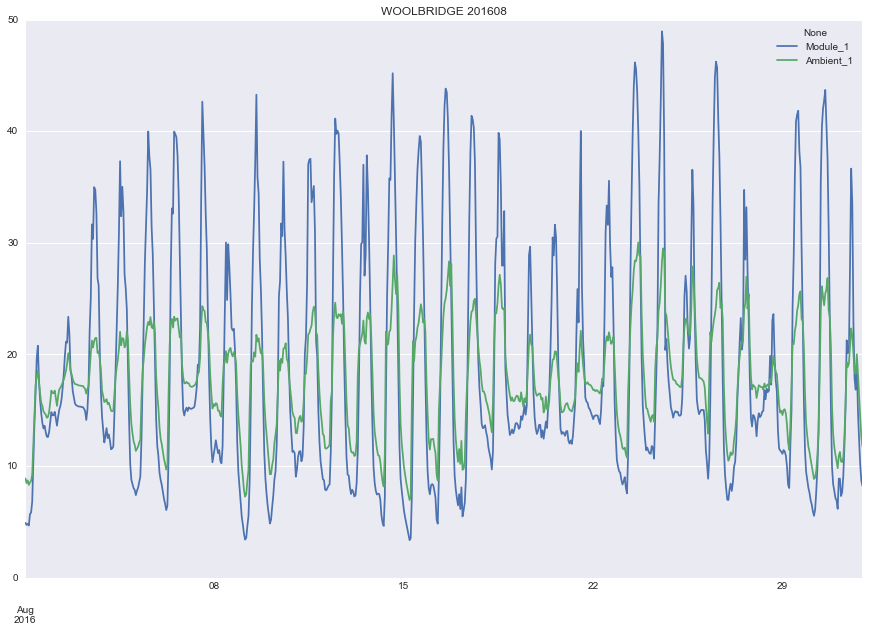

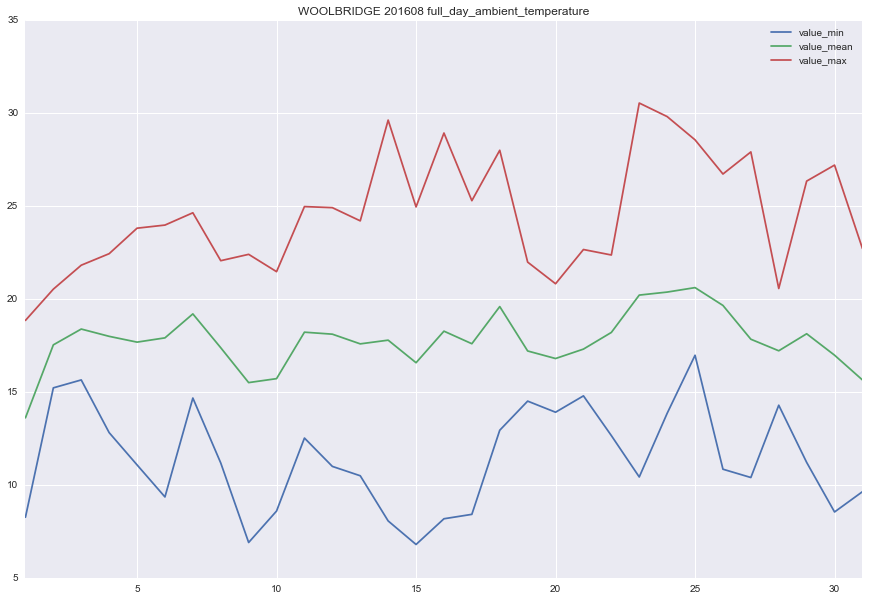

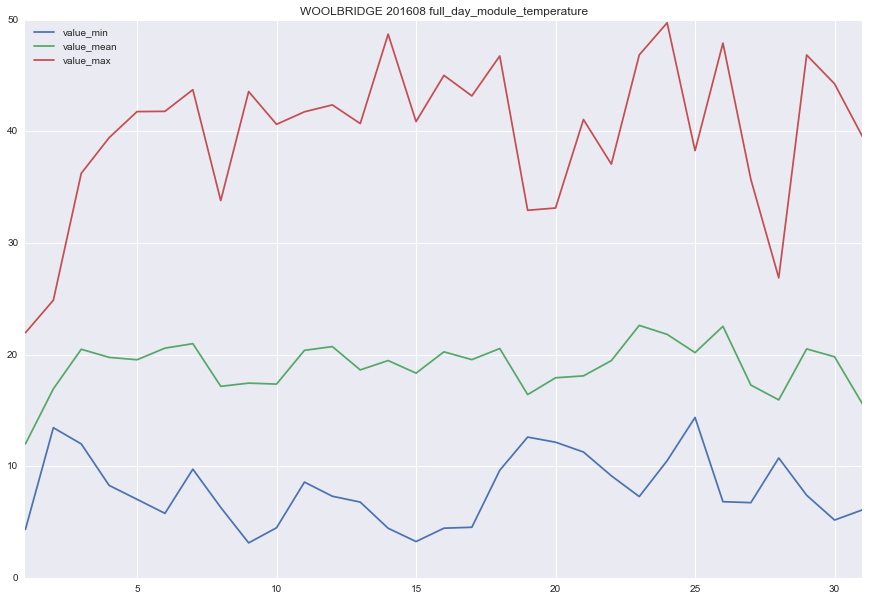

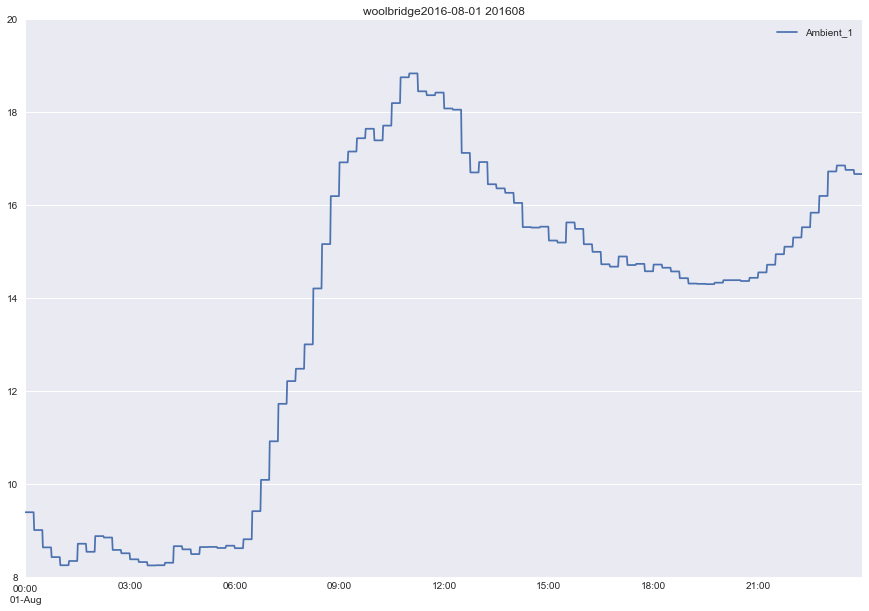

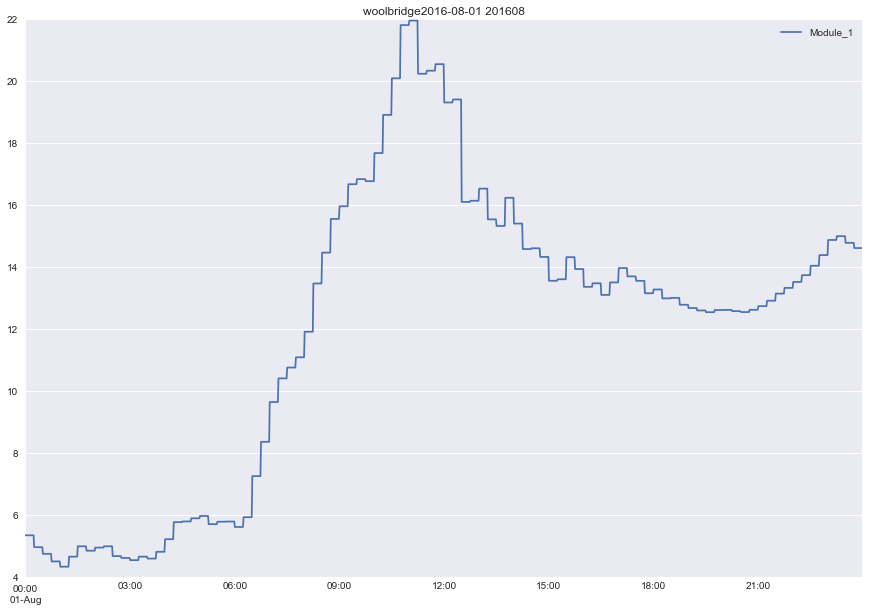

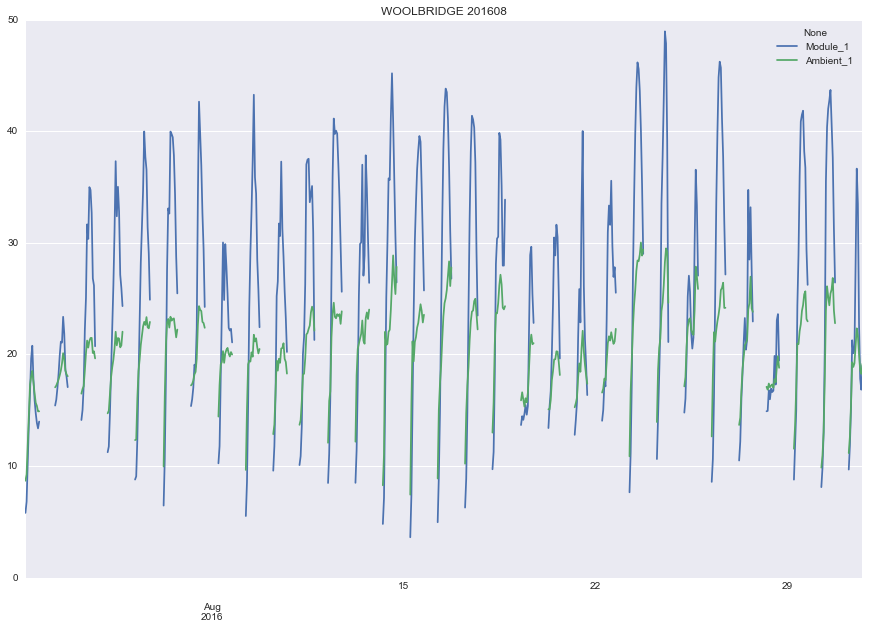

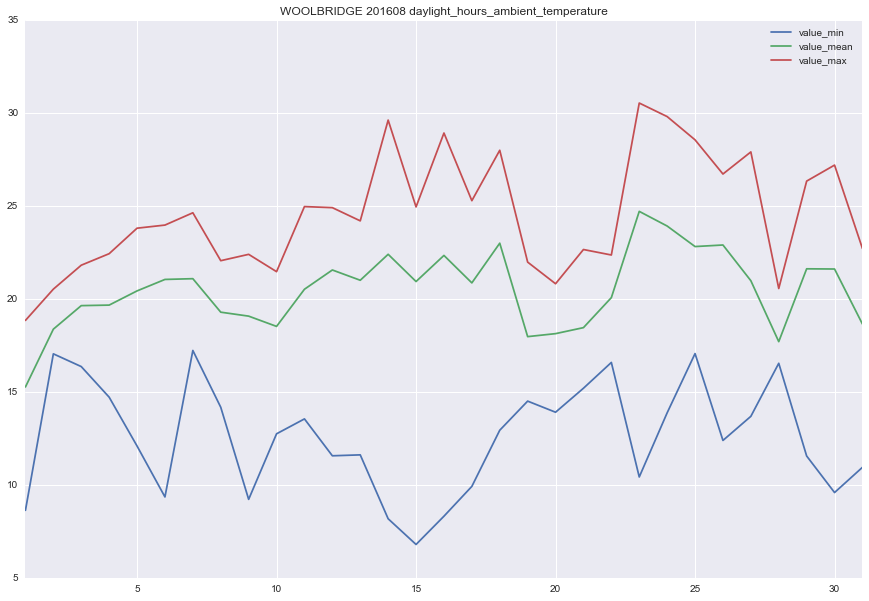

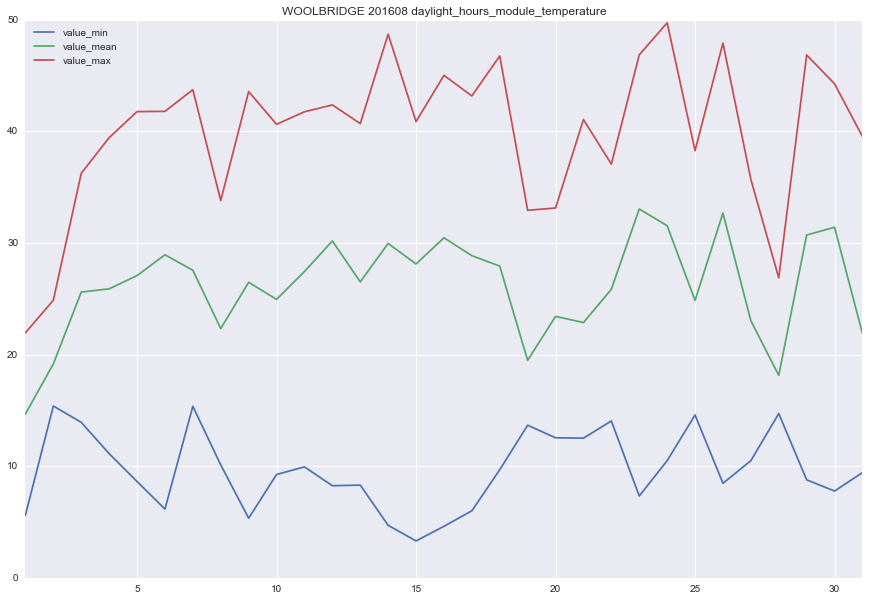

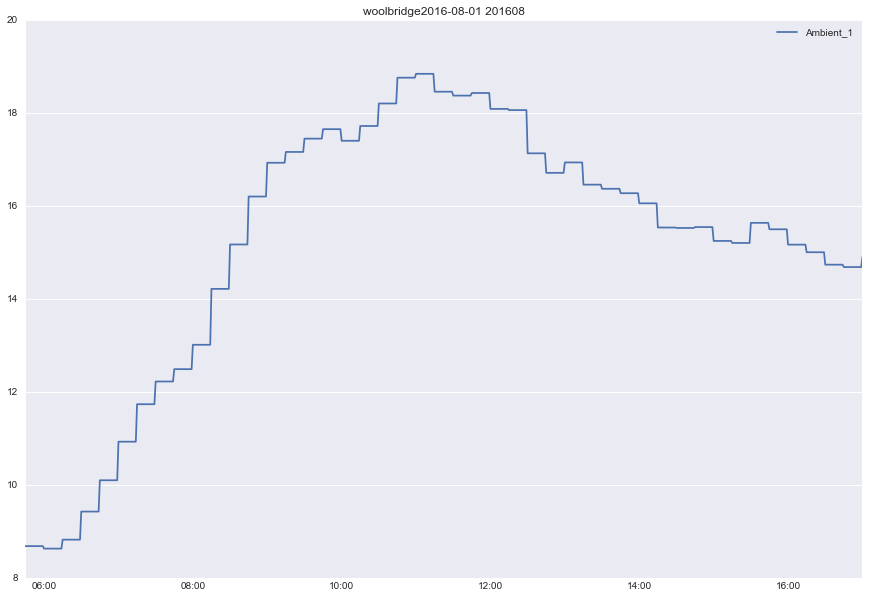

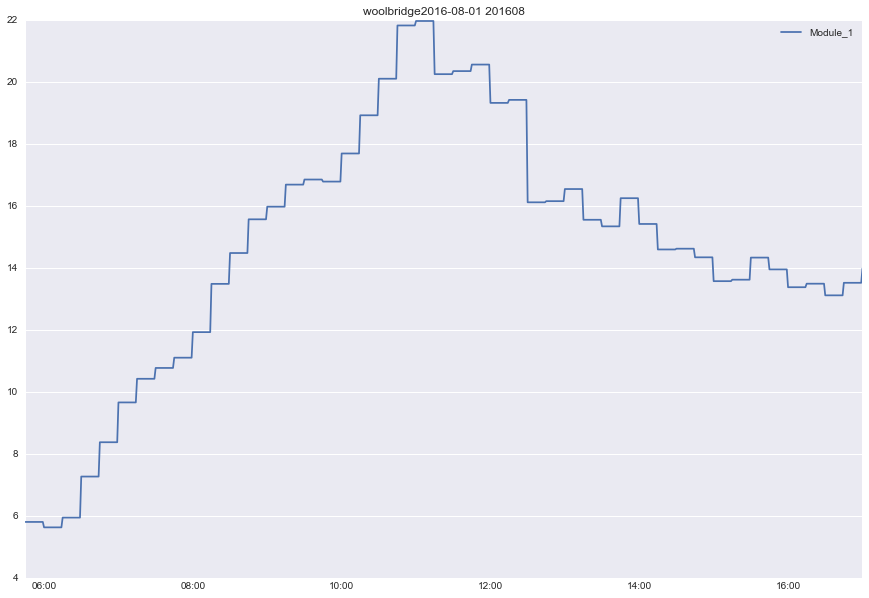

In [55]:
site=month_analysis_df.iloc[32].name
print('-----------'+site.upper()+'-----------')
test_date = '2016-08-01'
test_std =2
delete= True
month_df = full_day_agg(site, test_std, test_date, remove=delete)
daylight_month_df = daylight_agg(site, test_std, test_date, remove=delete)
# full_day_vs_daylight(month_df, daylight_month_df)

## Export to MySQL Table

In [56]:
to_db_df = pd.concat([month_df, daylight_month_df])

print(to_db_df.info())

# Print out the entire table
from IPython.display import display, HTML
HTML(to_db_df.to_html())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 1 to 31
Data columns (total 9 columns):
site_id                            124 non-null object
period_start                       124 non-null datetime64[ns]
period_end                         124 non-null datetime64[ns]
variable_name                      124 non-null object
value_min                          124 non-null float64
value_mean                         124 non-null float64
value_max                          124 non-null float64
calculation_completeness_factor    124 non-null float64
calculation_version                124 non-null object
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 9.7+ KB
None


,site_id,period_start,period_end,variable_name,value_min,value_mean,value_max,calculation_completeness_factor,calculation_version
1,woolbridge,2016-08-01,2016-08-01,full_day_ambient_temperature,8.257401,13.601674,18.838333,1.000000,0.1-dev-20160914
2,woolbridge,2016-08-02,2016-08-02,full_day_ambient_temperature,15.212279,17.523758,20.519028,1.000000,0.1-dev-20160914
3,woolbridge,2016-08-03,2016-08-03,full_day_ambient_temperature,15.637786,18.373936,21.806122,1.000000,0.1-dev-20160914
4,woolbridge,2016-08-04,2016-08-04,full_day_ambient_temperature,12.804931,17.981786,22.425400,1.000000,0.1-dev-20160914
5,woolbridge,2016-08-05,2016-08-05,full_day_ambient_temperature,11.070404,17.670482,23.796097,1.000000,0.1-dev-20160914
6,woolbridge,2016-08-06,2016-08-06,full_day_ambient_temperature,9.347260,17.899435,23.963333,1.000000,0.1-dev-20160914
7,woolbridge,2016-08-07,2016-08-07,full_day_ambient_temperature,14.664428,19.187660,24.624466,1.000000,0.1-dev-20160914
8,woolbridge,2016-08-08,2016-08-08,full_day_ambient_temperature,11.172592,17.368339,22.048965,1.000000,0.1-dev-20160914
9,woolbridge,2016-08-09,2016-08-09,full_day_ambient_temperature,6.898391,15.494511,22.390228,1.000000,0.1-dev-20160914
10,woolbridge,2016-08-10,2016-08-10,full_day_ambient_temperature,8.589386,15.707381,21.458679,1.000000,0.1-dev-20160914


## Export to database

In [71]:
# Only run this to export to database!

from sqlalchemy import or_, and_, extract, between

site_name=to_db_df.site_id.unique()[0]
start_date = to_db_df.period_start.min().strftime('%Y-%m-%d')
end_date = to_db_df.period_start.max().strftime('%Y-%m-%d')

try:
    # Delete existing records
    session=Session()
    existing = session.query(Temperature).filter(Temperature.c.period_start.between(start_date,end_date))\
            .filter(Temperature.c.site_id==site_name).delete(synchronize_session=False)
    session.commit()
except:
    pass
finally:
    # Upload new records
    with engine.begin() as connection:
        to_db_df.to_sql(name='performance_data_temperature', con=connection, if_exists='append', index=False)
    connection.close()

## Export to CSV

In [191]:
full_and_daylight_df = pd.concat([month_df, daylight_month_df])
csv_fname=str(yyyymm+'.csv')
full_and_daylight_df.to_csv(csv_fname, na_rep='NULL')

# full_and_daylight_df